In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


In [26]:
# =====================
# 1. Load Data
# =====================
df = pd.read_csv("C:\\Users\\Prudhvi\\Downloads\\Fraud.csv")

print("Shape:", df.shape)
print(df.head())

Shape: (1048575, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [27]:
# =====================
# 2. Feature Engineering (including step)
# =====================
# 'step' is in units of hours → derive useful time-dependent features
df['day'] = df['step'] // 24
df['hour'] = df['step'] % 24

# Cyclical encoding for hour (better than raw integer)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Drop raw step
df = df.drop(columns=['step'])
print(df.head())

       type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2  TRANSFER    181.00  C1305486145          181.0            0.00   
3  CASH_OUT    181.00   C840083671          181.0            0.00   
4   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  day  \
0  M1979787155             0.0             0.0        0               0    0   
1  M2044282225             0.0             0.0        0               0    0   
2   C553264065             0.0             0.0        1               0    0   
3    C38997010         21182.0             0.0        1               0    0   
4  M1230701703             0.0             0.0        0               0    0   

   hour  hour_sin  hour_cos  
0     1  0.258819  0.965926  
1     1  0.258819  0.965926  
2     1  0.258

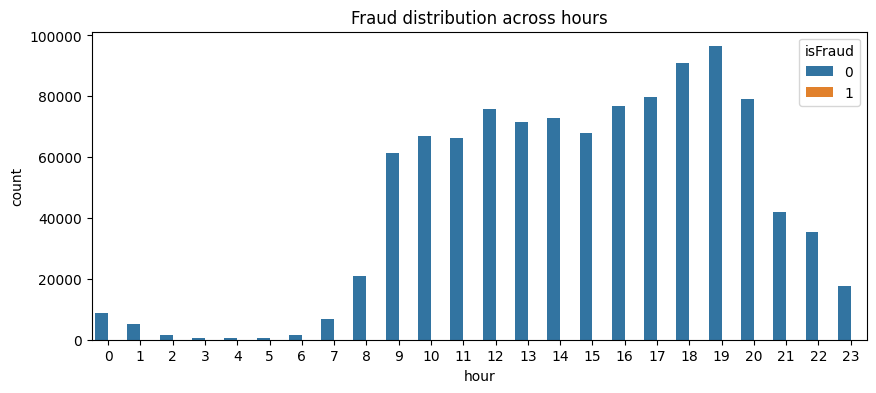

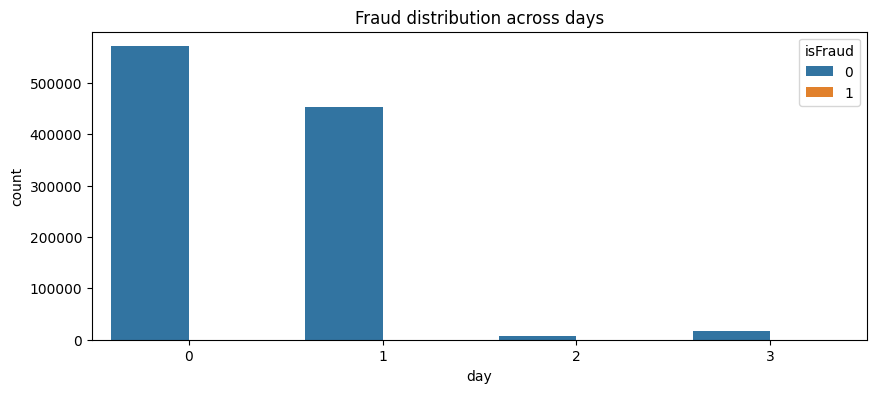

In [19]:
# =====================
# 3. Exploratory Data Analysis
# =====================
plt.figure(figsize=(10,4))
sns.countplot(x='hour', data=df, hue='isFraud')
plt.title("Fraud distribution across hours")
plt.show()

plt.figure(figsize=(10,4))
sns.countplot(x='day', data=df, hue='isFraud')
plt.title("Fraud distribution across days")
plt.show()

In [28]:
# =====================
# 4. Prepare Data
# =====================
# Encode categorical features
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Drop high-cardinality IDs
df = df.drop(columns=['nameOrig', 'nameDest'])

# Prepare X and y
X = df.drop(columns=['isFraud'])
y = df['isFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale numeric features
scaler = StandardScaler()
num_cols = X_train.select_dtypes(include=['int64','float64']).columns
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [29]:
# =====================
# 5. Handle with SMOTE
# =====================
# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: isFraud
0    733203
1       799
Name: count, dtype: int64
After SMOTE: isFraud
0    733203
1    733203
Name: count, dtype: int64



Training RandomForest...
Accuracy: 0.9993483229647808
ROC AUC: 0.988267683631115
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       0.66      0.82      0.73       343

    accuracy                           1.00    314573
   macro avg       0.83      0.91      0.87    314573
weighted avg       1.00      1.00      1.00    314573



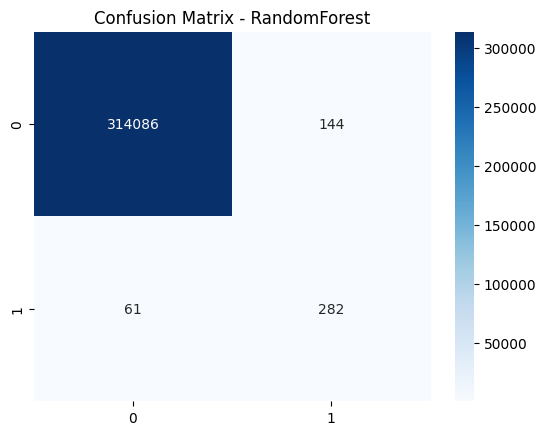


Training XGBoost...
Accuracy: 0.9988969174086778
ROC AUC: 0.9922494006126689
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       0.50      0.87      0.63       343

    accuracy                           1.00    314573
   macro avg       0.75      0.94      0.82    314573
weighted avg       1.00      1.00      1.00    314573



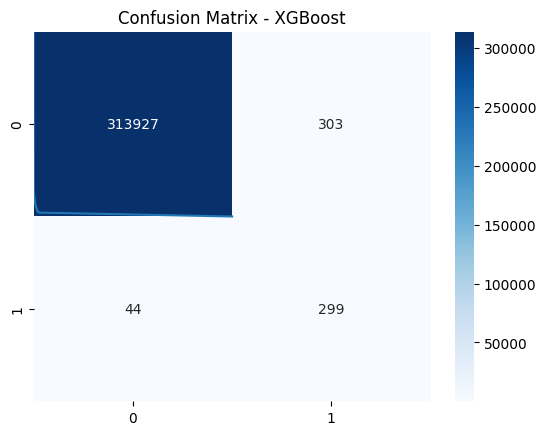

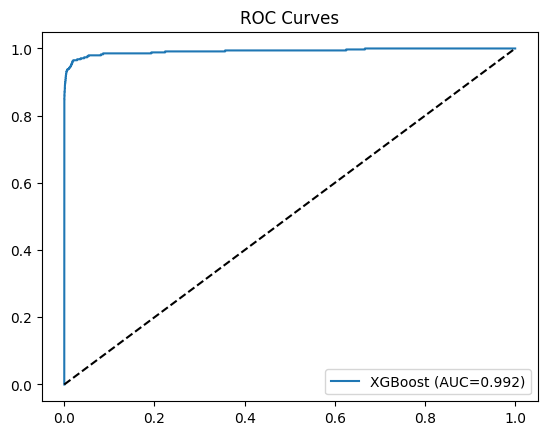

In [31]:
# =====================
# 6. Train Models
# =====================
models = {
"RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
"XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=8, random_state=42, n_jobs=-1, eval_metric='logloss')
}


results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    
    results[name] = {
    "accuracy": accuracy_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba),
    "report": classification_report(y_test, y_pred)
    }
    
    
    print("Accuracy:", results[name]["accuracy"])
    print("ROC AUC:", results[name]["roc_auc"])
    print(results[name]["report"])
    
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={results[name]['roc_auc']:.3f})")


plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("ROC Curves")
plt.show()


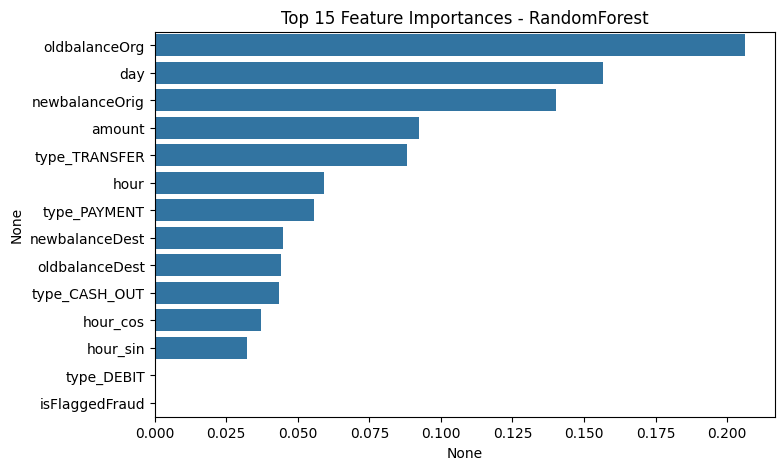

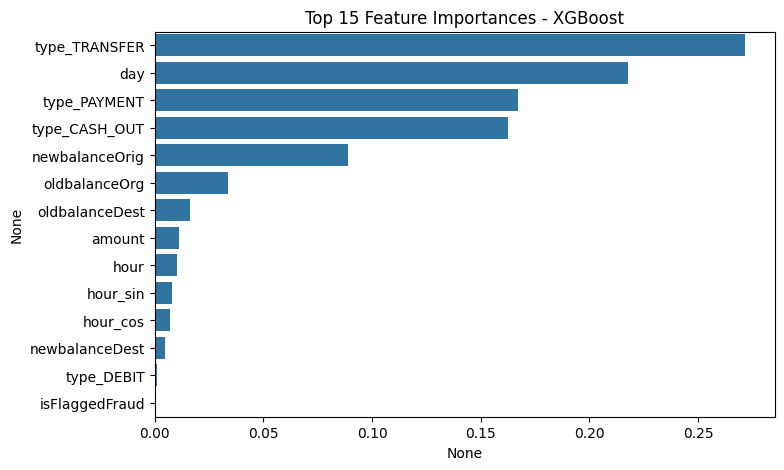

In [34]:
# =====================
# 7. Feature Importance
# =====================
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
    

        plt.figure(figsize=(8,5))
        sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15])
        plt.title(f"Top 15 Feature Importances - {name}")
        plt.show()